# PHYS 555 Convolutional Neural Network

---

In this lab we will explore how to build a Convolutional Neural Network (CNN) for a very common example: recognizing hand written digits. This was one of the first data to be used with CNN from the [MNIST Database](https://en.wikipedia.org/wiki/MNIST_database). The data set is small and simple so that you can play with a lot of configurations and compare to many other models.

![Example MNIST](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)


## Setup your environment

First make sure you setup your environment on the Google Colab to be run with GPU: Go to Runtime->Change Running Type. 

Alternatively, follow this [Colab Settting tutorial](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d)

In [1]:
# python modules we will need in this lab

# python scientific libraries
import numpy as np
import matplotlib.pyplot as plt

# neural networks library
import torch 
import torch.nn as nn

# data mangling library for pytorch computer vision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# initialize stuff for jupyter notebook online
%matplotlib inline

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define some variables for your data
data_dir = './data'

## Working with  datasets

A [torch.utils.data.dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)
is an object that will allow us to access the data efficiently. Pytorch already inherits dataset within the torchvision module for [common machine learning datasets](https://pytorch.org/docs/stable/torchvision/datasets.html).

We need to load the  [MNIST](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.MNIST) dataset and provides a training set and a test set (set by the train flag). Because it is such a common dataset, data loading and transforming is built-in within pytorch and easy.

In [2]:
# MNIST dataset contains images and labels
# Download the datasets locally
train_dataset = datasets.MNIST(root=data_dir, 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root=data_dir, 
                              train=False, 
                              transform=transforms.ToTensor(),
                              download=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



We define functions to access and load the data at training and test time. We shuffle the training dataset to minimize bias in training. The [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) can be very useful when dealing with very large datasets.

In [3]:
# Define batch size (it is a hyper-parameter)
batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

As always let's take a look at the data and its distribution.

In [4]:
# full sample
print('Number of training samples:', len(train_dataset))
print('Number of test samples', len(test_dataset))


# now for a batch
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

Number of training samples: 60000
Number of test samples 10000
torch.Size([64, 1, 28, 28])


In [5]:
plt.figure(figsize=(7,7))
plt.imshow(example_data[9][0], cmap='gray_r', interpolation='none')
plt.xticks([])
plt.yticks([])

([], [])

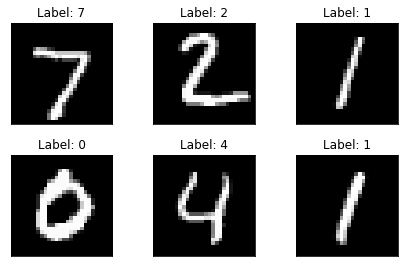

In [6]:
# show some examples

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

The data contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. The pixel-value is an integer between 0 and 255, inclusive.

Note our data is not normalized.


## Building our first model
We now are going to build a very simplle Convolutional Neural Network (CNN) with pytorch. Typically is is done constructing a Python object that inherits from [torch.nn.module](https://pytorch.org/docs/stable/nn.html). Here we build it with 2 convolutional layers CNN with ReLU and Maxpooling, using one fully connected layer.

In [22]:
num_classes = 10

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(4*4*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## Training the model

To train the model, let us define a cross-entropy loss (see the torch.nn.module doc referenced above) and we will use a Stochastic Gradient Descent optimizer. Calling loss.backward() followed by optimizer.step() updates the model parameters. We will define some function to use.

In [23]:
# choose your loss.
criterion = nn.CrossEntropyLoss()

def train_epoch(epoch, log_interval, model, data_loader, optimizer):
    model.train()
    for batch_idx, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)      
        # This will zero out the gradients for this batch.
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        # Compute gradient dl/dx for all Variables
        loss.backward()
        # Do a one-step update on our parameter.
        optimizer.step()
        
        # print stuff
        if batch_idx % log_interval == 0:
            print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item()))

def test(model, data_loader):
    model.eval()
    with torch.no_grad():
      total = 0
      correct = 0
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test accuracy of the model: {}%'.format(100 * correct / total))


In [24]:
num_epochs = 5
learning_rate = 0.01
log_interval = 100 

use_gpu = torch.cuda.is_available()
model = CNN().to(device)

if use_gpu:
    model = model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    
# Run the training loop over the epochs (evaluate after each)
for epoch in range(1, num_epochs+ 1):
  train_epoch(epoch, log_interval, model, train_loader, optimizer)
  
  
test(model, test_loader)

Train epoch: 1 [0/60000 (0%)]	Loss: 2.310701
Train epoch: 1 [6400/60000 (11%)]	Loss: 2.267870
Train epoch: 1 [12800/60000 (21%)]	Loss: 2.113347
Train epoch: 1 [19200/60000 (32%)]	Loss: 1.173732
Train epoch: 1 [25600/60000 (43%)]	Loss: 0.543630
Train epoch: 1 [32000/60000 (53%)]	Loss: 0.400412
Train epoch: 1 [38400/60000 (64%)]	Loss: 0.424936
Train epoch: 1 [44800/60000 (75%)]	Loss: 0.295575
Train epoch: 1 [51200/60000 (85%)]	Loss: 0.306984
Train epoch: 1 [57600/60000 (96%)]	Loss: 0.143042
Train epoch: 2 [0/60000 (0%)]	Loss: 0.383650
Train epoch: 2 [6400/60000 (11%)]	Loss: 0.304225
Train epoch: 2 [12800/60000 (21%)]	Loss: 0.203477
Train epoch: 2 [19200/60000 (32%)]	Loss: 0.422409
Train epoch: 2 [25600/60000 (43%)]	Loss: 0.415873
Train epoch: 2 [32000/60000 (53%)]	Loss: 0.307607
Train epoch: 2 [38400/60000 (64%)]	Loss: 0.096644
Train epoch: 2 [44800/60000 (75%)]	Loss: 0.113776
Train epoch: 2 [51200/60000 (85%)]	Loss: 0.292753
Train epoch: 2 [57600/60000 (96%)]	Loss: 0.254513
Train epoch:

We can see key information about training in the output:

- At prescribed logging intervals, the training process prints out how many samples in the training set it has gone through in the current epoch, and the loss of the current training mini-batch.
- We can see that over the epochs, on the testing set, the loss decreases and the accuracy increases, suggesting that the model is indeed improving, even though at batch level there might be fluctuations.


Our initial model is not very good so you will need to work on improving it!


## Practical exercises

1. Play with the CNN model.
Change:
    - kernel size {3,5,7},  padding {2}, stride {1,2}
    - number of fully connected layers: {1,2,3}
    - number of convolutional layers {3,1}   
 
 Retrain with some of these combinations. 
 Write your observations  below in notebook cells.

In [31]:
num_classes = 10

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5), #is there a way to determine the size? or how did you know the 4*4*32? if i try to comment out the second layer everything breaks
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(4*4*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [32]:
num_epochs = 5
learning_rate = 0.01
log_interval = 100 

use_gpu = torch.cuda.is_available()
model = CNN().to(device)

if use_gpu:
    model = model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    
# Run the training loop over the epochs (evaluate after each)
for epoch in range(1, num_epochs+ 1):
  train_epoch(epoch, log_interval, model, train_loader, optimizer)
  
  
test(model, test_loader)

RuntimeError: ignored

2. Play with the optimization. Change:
    - the optimization algorithm: switch to Adam
    - learning rate {0.1, 0.001}
    - number of epochs {10,20}
    
  Retrain with some of these combinations.  Write your observations below.



2. Normalisation. 

In the datasets loading above, we did not normalize the inputs, we loaded directly the images into array (ToTensor). Modify the code to normalize the inputs with the Normalize function.
  
Retrain.  Write your observations.



3. Validation.

  - Write code to split your training set with a validation set.
  - Write code to tweak your classification model with validation. Evaluate with your test set.
  - Save the most accurate model you have built given all the modifications in the previous questions.

4. Optional: Regression
  - Before doing regression, plot a confusion matrix for all the numbers. What do you notice?
  - Modify the network to be a regression. That means the output to be one continuous variable between 0 and 10 instead of using a categorical variable (hint: play with last layer and loss function). 
  - Make a scatter plot of true label vs. predicted label. 
Write your observations. For example: does the network need to change much compared to the classification task? 